<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/beans_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds



In [2]:
!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz


--2023-10-03 18:11:45--  https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/beans_dataset.tar.gz
Resolving dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)... 52.217.94.4, 3.5.29.59, 3.5.25.237, ...
Connecting to dsserver-prod-resources-1.s3.amazonaws.com (dsserver-prod-resources-1.s3.amazonaws.com)|52.217.94.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179790562 (171M) [application/x-gzip]
Saving to: ‘beans_dataset.tar.gz’

beans_dataset.tar.g 100%[===================>] 171.46M  40.8MB/s    in 4.4s    

2023-10-03 18:11:50 (39.4 MB/s) - ‘beans_dataset.tar.gz’ saved [179790562/179790562]



In [3]:
import tarfile

In [4]:
with tarfile.open('beans_dataset.tar.gz') as tar:
    tar.extractall(path='data/')

In [5]:
# load the datasets
train = tf.keras.utils.image_dataset_from_directory('/content/data/beans/train')
val = tf.keras.utils.image_dataset_from_directory('/content/data/beans/validation')
test = tf.keras.utils.image_dataset_from_directory('/content/data/beans/test')



Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [6]:
example = train.take(1)

In [7]:
for x, y in train.take(1):
    print(x.shape, y.shape)

(32, 256, 256, 3) (32,)


1


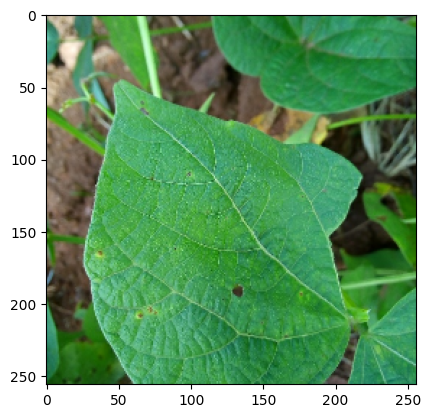

In [8]:
img = x[7]
img = img/255.0
print(y[7].numpy())
plt.imshow(img)



In [3]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    #image = tf.image.resize(image, (250, 250))
    image = image/255.0
    label = tf.one_hot(label, 3)
    return image, label


In [7]:
augnment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.2)
])

In [4]:
train_ds = train.map(preprocess).cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val.map(preprocess).cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.map(preprocess).cache().shuffle(10)


In [9]:
def simple_model():
  inputs = tf.keras.Input(shape=(256, 256, 3))
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu')(inputs)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128,activation = 'relu')(x)
  x = tf.keras.layers.Dense(3, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [10]:
model = simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 128)               66064512  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                             

In [11]:
model_chekpoint = tf.keras.callbacks.ModelCheckpoint('beans_model.h5', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor = 'val_loss')

history = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[early_stopping])



Epoch 1/40
33/33 [==============================] - 12s 40ms/step - loss: 19.4914 - accuracy: 0.3849 - val_loss: 0.9262 - val_accuracy: 0.5865
Epoch 2/40
33/33 [==============================] - 1s 22ms/step - loss: 0.8718 - accuracy: 0.6161 - val_loss: 0.7718 - val_accuracy: 0.6992
Epoch 3/40
33/33 [==============================] - 1s 21ms/step - loss: 0.5800 - accuracy: 0.7747 - val_loss: 0.6387 - val_accuracy: 0.7669
Epoch 4/40
33/33 [==============================] - 1s 21ms/step - loss: 0.3903 - accuracy: 0.8501 - val_loss: 0.5675 - val_accuracy: 0.8195
Epoch 5/40
33/33 [==============================] - 1s 22ms/step - loss: 0.2816 - accuracy: 0.8975 - val_loss: 0.5859 - val_accuracy: 0.7744
Epoch 6/40
33/33 [==============================] - 1s 21ms/step - loss: 0.1982 - accuracy: 0.9420 - val_loss: 0.6117 - val_accuracy: 0.7444
Epoch 7/40
33/33 [==============================] - 1s 21ms/step - loss: 0.1378 - accuracy: 0.9720 - val_loss: 0.5504 - val_accuracy: 0.7669
Epoch 8/40


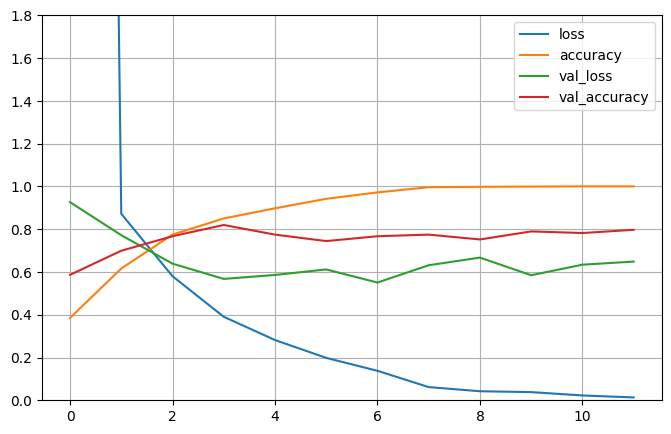

In [12]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.8)
plt.show()



In [13]:
model.evaluate(test_ds)


4/4 [==============================] - 0s 14ms/step - loss: 0.7566 - accuracy: 0.7656


[0.756563127040863, 0.765625]

In [14]:
model.evaluate(val_ds)

5/5 [==============================] - 0s 16ms/step - loss: 0.6485 - accuracy: 0.7970


[0.648513913154602, 0.7969924807548523]

In [15]:
augnment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.2)
])

In [16]:
def simple_with_aug(aug_layers):
  inputs = tf.keras.Input(shape=(256, 256, 3))
  x = aug_layers(inputs)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu')(inputs)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128,activation = 'relu')(x)
  x = tf.keras.layers.Dense(3, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=x)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [17]:
model2 = simple_with_aug(augnment)
model_chekpoint = tf.keras.callbacks.ModelCheckpoint('model2.h5', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor = 'val_loss', restore_best_weights=True)

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[early_stopping])

Epoch 1/40
33/33 [==============================] - 3s 45ms/step - loss: 11.8745 - accuracy: 0.4101 - val_loss: 1.1104 - val_accuracy: 0.5414
Epoch 2/40
33/33 [==============================] - 1s 30ms/step - loss: 0.7661 - accuracy: 0.6692 - val_loss: 0.7228 - val_accuracy: 0.7368
Epoch 3/40
33/33 [==============================] - 1s 30ms/step - loss: 0.3929 - accuracy: 0.8607 - val_loss: 0.7225 - val_accuracy: 0.7519
Epoch 4/40
33/33 [==============================] - 1s 21ms/step - loss: 0.1735 - accuracy: 0.9565 - val_loss: 0.8298 - val_accuracy: 0.7368
Epoch 5/40
33/33 [==============================] - 1s 21ms/step - loss: 0.0633 - accuracy: 0.9894 - val_loss: 0.7645 - val_accuracy: 0.7368
Epoch 6/40
33/33 [==============================] - 1s 30ms/step - loss: 0.0260 - accuracy: 0.9981 - val_loss: 0.7161 - val_accuracy: 0.7444
Epoch 7/40
33/33 [==============================] - 1s 21ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.7778 - val_accuracy: 0.7444
Epoch 8/40
3

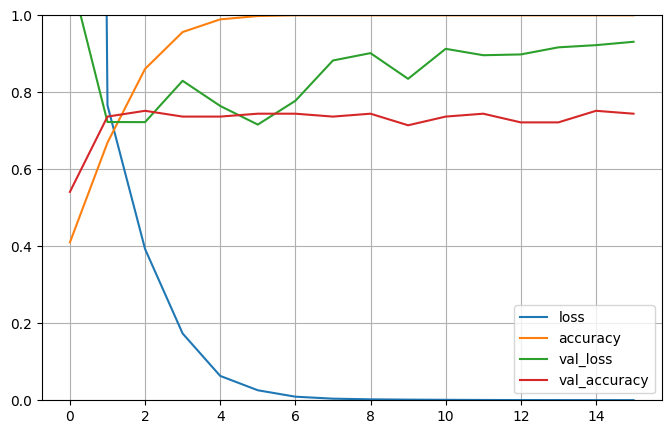

In [18]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [19]:
model2.evaluate(test_ds)


4/4 [==============================] - 0s 16ms/step - loss: 0.6436 - accuracy: 0.7734


[0.6435772180557251, 0.7734375]

In [20]:
model2.evaluate(val_ds)

5/5 [==============================] - 0s 22ms/step - loss: 0.7161 - accuracy: 0.7444


[0.7161141037940979, 0.7443609237670898]

In [21]:
augnment2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [22]:
model3 = simple_with_aug(augnment2)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor = 'val_loss', restore_best_weights=True)
model3.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[early_stopping])



Epoch 1/40
33/33 [==============================] - 3s 44ms/step - loss: 15.7164 - accuracy: 0.4178 - val_loss: 1.0880 - val_accuracy: 0.4586
Epoch 2/40
33/33 [==============================] - 1s 31ms/step - loss: 0.7976 - accuracy: 0.6538 - val_loss: 0.8013 - val_accuracy: 0.6316
Epoch 3/40
33/33 [==============================] - 1s 30ms/step - loss: 0.5733 - accuracy: 0.7756 - val_loss: 0.6182 - val_accuracy: 0.7068
Epoch 4/40
33/33 [==============================] - 1s 30ms/step - loss: 0.3782 - accuracy: 0.8723 - val_loss: 0.5408 - val_accuracy: 0.7368
Epoch 5/40
33/33 [==============================] - 1s 30ms/step - loss: 0.2471 - accuracy: 0.9246 - val_loss: 0.5360 - val_accuracy: 0.7820
Epoch 6/40
33/33 [==============================] - 1s 22ms/step - loss: 0.1525 - accuracy: 0.9642 - val_loss: 0.5401 - val_accuracy: 0.8271
Epoch 7/40
33/33 [==============================] - 1s 21ms/step - loss: 0.0929 - accuracy: 0.9836 - val_loss: 0.5543 - val_accuracy: 0.7820
Epoch 8/40
3

In [23]:
model3.evaluate(test_ds)



4/4 [==============================] - 0s 13ms/step - loss: 0.5481 - accuracy: 0.7656


[0.5481218099594116, 0.765625]

In [24]:
model3.evaluate(val_ds)

5/5 [==============================] - 0s 19ms/step - loss: 0.5360 - accuracy: 0.7820


[0.5360060334205627, 0.7819548845291138]

In [5]:
def full_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((256, 256, 3)),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax)
    ], name='cnn_model')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
model4 = full_cnn()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor = 'val_loss', restore_best_weights=True)
hisory4 = model4.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
33/33 [==============================] - 12s 68ms/step - loss: 1.1120 - accuracy: 0.3221 - val_loss: 1.0986 - val_accuracy: 0.3308
Epoch 2/100
33/33 [==============================] - 1s 38ms/step - loss: 1.0983 - accuracy: 0.3472 - val_loss: 1.0965 - val_accuracy: 0.3759
Epoch 3/100
33/33 [==============================] - 1s 39ms/step - loss: 1.0551 - accuracy: 0.4642 - val_loss: 1.0471 - val_accuracy: 0.4211
Epoch 4/100
33/33 [==============================] - 1s 38ms/step - loss: 1.0334 - accuracy: 0.4391 - val_loss: 0.7972 - val_accuracy: 0.6617
Epoch 5/100
33/33 [==============================] - 1s 38ms/step - loss: 0.8872 - accuracy: 0.5909 - val_loss: 0.6842 - val_accuracy: 0.6842
Epoch 6/100
33/33 [==============================] - 1s 38ms/step - loss: 0.8149 - accuracy: 0.6325 - val_loss: 0.6626 - val_accuracy: 0.6692
Epoch 7/100
33/33 [==============================] - 1s 38ms/step - loss: 0.7395 - accuracy: 0.6799 - val_loss: 0.7005 - val_accuracy: 0.6992
Epoch

In [7]:
model4.evaluate(test_ds)


4/4 [==============================] - 0s 19ms/step - loss: 0.1624 - accuracy: 0.9531


[0.16235171258449554, 0.953125]

In [8]:
model4.evaluate(val_ds)


5/5 [==============================] - 0s 20ms/step - loss: 0.1233 - accuracy: 0.9549


[0.12333280593156815, 0.9548872113227844]

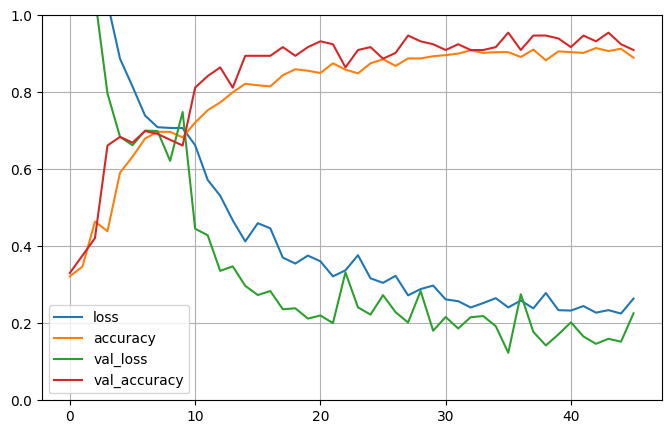

In [10]:
import pandas as pd
pd.DataFrame(hisory4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [34]:
# evaluate the full_cnn ussing lr
model5 = full_cnn()

LR = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch/20), verbose=0)
history5 = model5.fit(train_ds, epochs = 100, validation_data=val_ds, callbacks= [LR])




Epoch 1/100
33/33 [==============================] - 5s 43ms/step - loss: 1.0967 - accuracy: 0.3743 - val_loss: 1.0917 - val_accuracy: 0.3459 - lr: 1.0000e-05
Epoch 2/100
33/33 [==============================] - 1s 38ms/step - loss: 1.0877 - accuracy: 0.5300 - val_loss: 1.0784 - val_accuracy: 0.5489 - lr: 1.1220e-05
Epoch 3/100
33/33 [==============================] - 1s 38ms/step - loss: 1.0707 - accuracy: 0.5832 - val_loss: 1.0552 - val_accuracy: 0.5038 - lr: 1.2589e-05
Epoch 4/100
33/33 [==============================] - 1s 38ms/step - loss: 1.0389 - accuracy: 0.5774 - val_loss: 0.9992 - val_accuracy: 0.5564 - lr: 1.4125e-05
Epoch 5/100
33/33 [==============================] - 1s 38ms/step - loss: 0.9795 - accuracy: 0.6035 - val_loss: 0.9177 - val_accuracy: 0.6466 - lr: 1.5849e-05
Epoch 6/100
33/33 [==============================] - 1s 41ms/step - loss: 0.9180 - accuracy: 0.6044 - val_loss: 0.8777 - val_accuracy: 0.5639 - lr: 1.7783e-05
Epoch 7/100
33/33 [===========================

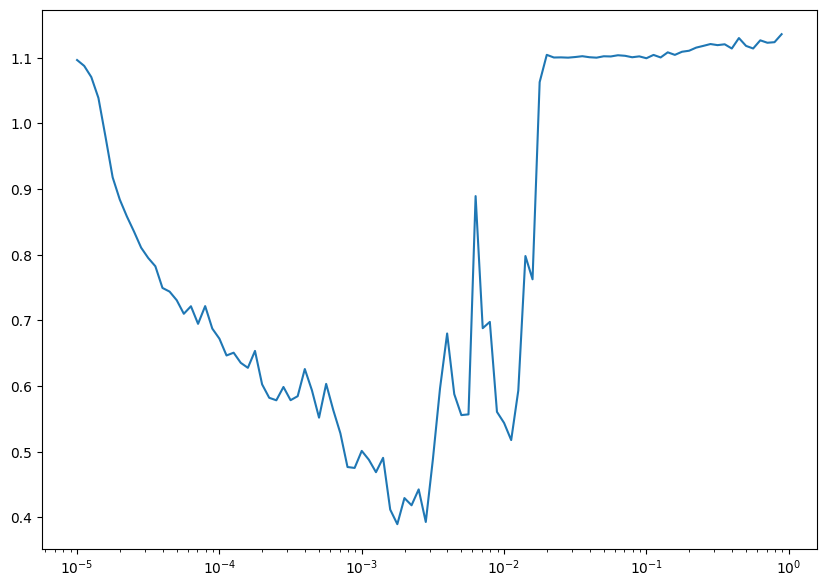

In [36]:
plt.figure(figsize=(10,7))
learning_rates = 1e-5 * 10 ** (np.arange(100)/20)
plt.semilogx(learning_rates, history5.history['loss'])
plt.show()

In [56]:
learning_rate = 1e-3 *0.7
learning_rate

0.0007

In [64]:
# evaluate the full_cnn ussing lr
model6 = full_cnn()
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

RLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-5)
ES = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience = 8)
history6 = model6.fit(train_ds, epochs = 100, validation_data=val_ds, callbacks= [ES, RLR])

Epoch 1/100
33/33 [==============================] - 4s 44ms/step - loss: 1.1000 - accuracy: 0.3617 - val_loss: 1.0933 - val_accuracy: 0.3308 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 38ms/step - loss: 1.0280 - accuracy: 0.4342 - val_loss: 1.0027 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 38ms/step - loss: 1.0100 - accuracy: 0.4642 - val_loss: 0.9689 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 37ms/step - loss: 0.9600 - accuracy: 0.5397 - val_loss: 0.9791 - val_accuracy: 0.4887 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 38ms/step - loss: 0.9113 - accuracy: 0.5725 - val_loss: 0.7915 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 43ms/step - loss: 0.8406 - accuracy: 0.6257 - val_loss: 0.7251 - val_accuracy: 0.6617 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 1s 41ms/step - lo

In [65]:
model6.evaluate(test_ds)

4/4 [==============================] - 0s 19ms/step - loss: 0.3869 - accuracy: 0.8984


[0.3869422376155853, 0.8984375]

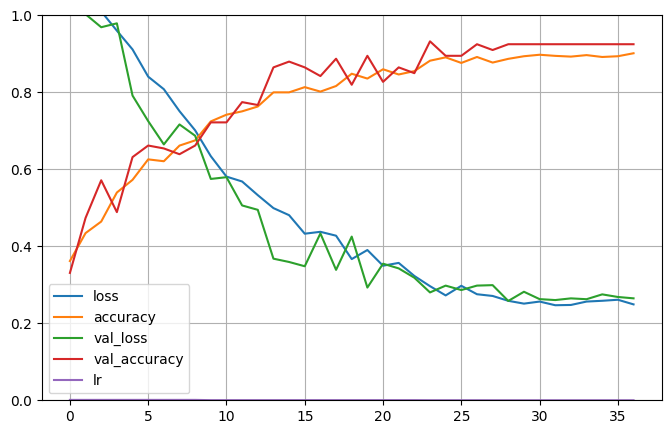

In [66]:
pd.DataFrame(history6.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [37]:
num_filters = 15
filter_size = 10
pool_size = 4
strides = 2
fc_output = 128
drop_probability = 0.25
learning_rate = 0.0004

def cnn_2():
  model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((256, 256, 3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.Conv2D(num_filters, filter_size,
                          strides = strides, padding = 'same', activation = 'relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(pool_size = pool_size),
    tf.keras.layers.Dropout(drop_probability),
    tf.keras.layers.Conv2D(num_filters, filter_size, strides = strides, padding = 'same',
                          activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = pool_size),
    tf.keras.layers.Dropout(drop_probability),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(fc_output, activation = 'relu'),

    tf.keras.layers.Dense(3, activation = 'softmax'),
  ])
  model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy'])
  return model

In [38]:
model8 = cnn_2()
model8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_9 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_9 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_9 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 15)      4515      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 32, 32, 15)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 32, 32, 15)      

In [39]:
model8 = cnn_2()

ES = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience =10)
history8 = model8.fit(train_ds, epochs = 100, validation_data=val_ds, callbacks= [ES])

Epoch 1/100
33/33 [==============================] - 3s 25ms/step - loss: 1.2136 - accuracy: 0.3337 - val_loss: 1.0927 - val_accuracy: 0.4436
Epoch 2/100
33/33 [==============================] - 1s 19ms/step - loss: 1.0675 - accuracy: 0.4526 - val_loss: 1.0329 - val_accuracy: 0.5489
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 1.0006 - accuracy: 0.5019 - val_loss: 0.9141 - val_accuracy: 0.5940
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 0.9396 - accuracy: 0.5648 - val_loss: 0.8571 - val_accuracy: 0.6241
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 0.9002 - accuracy: 0.5783 - val_loss: 0.7788 - val_accuracy: 0.6617
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 0.8526 - accuracy: 0.5996 - val_loss: 0.7381 - val_accuracy: 0.6767
Epoch 7/100
33/33 [==============================] - 1s 18ms/step - loss: 0.8232 - accuracy: 0.6383 - val_loss: 0.7331 - val_accuracy: 0.7368
Epoch 

<Axes: >

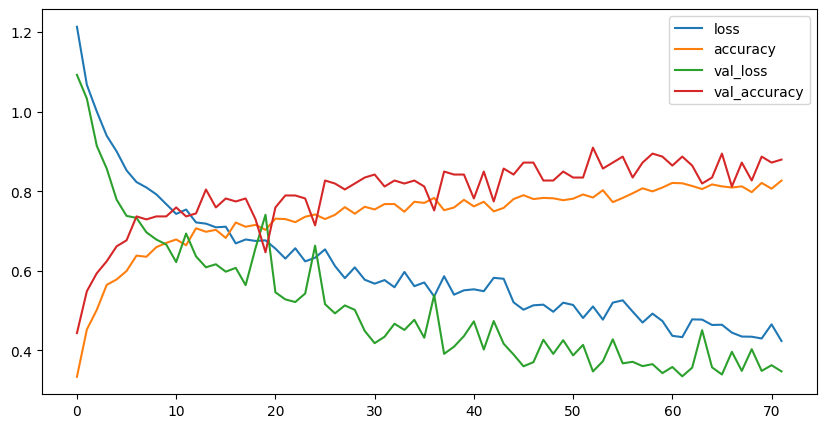

In [40]:
pd.DataFrame(history8.history).plot(figsize = (10,5))

In [41]:
model8.evaluate(test_ds)

4/4 [==============================] - 0s 15ms/step - loss: 0.4010 - accuracy: 0.8281


[0.40102481842041016, 0.828125]

In [252]:
def vgg16():
  inputs = tf.keras.Input(shape=(256, 256, 3))

  aug = tf.keras.Sequential([
      tf.keras.layers.RandomFlip(),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2)
  ])
  x = aug(inputs)

  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.MaxPooling2D((2,2), strides = 2)(x)

  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.MaxPooling2D((2,2), strides = 2)(x)

  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.MaxPooling2D((2,2), strides = 2)(x)

  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.MaxPooling2D((2,2), strides = 2)(x)

  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.MaxPooling2D((2,2), strides = 2)(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(256, activation = 'relu')(x)
  x = tf.keras.layers.Dense(128, activation = 'relu')(x)
  x = tf.keras.layers.Dense(3, activation = 'softmax')(x)

  model = tf.keras.Model(inputs = inputs, outputs = x)
  model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [253]:
vgg_model = vgg16()
vgg_model.summary()

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_19 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_187 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 conv2d_188 (Conv2D)         (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_123 (MaxPool  (None, 128, 128, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_189 (Conv2D)         (None, 128, 128, 128)     73856     
                                                          

In [254]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [255]:
vgg_model = vgg16()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor = 'val_loss', restore_best_weights=True)

history_vgg = vgg_model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])



Epoch 1/50
33/33 [==============================] - 9s 174ms/step - loss: 1.0986 - accuracy: 0.3346 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 2/50
33/33 [==============================] - 5s 162ms/step - loss: 1.0986 - accuracy: 0.3327 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 3/50
33/33 [==============================] - 5s 166ms/step - loss: 1.0986 - accuracy: 0.3337 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 4/50
33/33 [==============================] - 5s 162ms/step - loss: 1.0986 - accuracy: 0.3279 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 5/50
33/33 [==============================] - 5s 164ms/step - loss: 1.0986 - accuracy: 0.3327 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 6/50
33/33 [==============================] - 5s 163ms/step - loss: 1.0986 - accuracy: 0.3375 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 7/50
33/33 [==============================] - 5s 163ms/step - loss: 1.0986 - accuracy: 0.3356 - val_loss: 1.0986 - val_accuracy: 0.3383
Epoch 

KeyboardInterrupt: ignored